In [1]:
#!nvidia-smi

In [2]:
#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=0

In [3]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility
cur_dir = os.getcwd()
ckpt_dir = 'checkpoints'

### Modify !!! #############
#save_filename = 'jwlee_gap.ckpt'
save_filename = 'jwlee_gap_nopool.ckpt'
############################

In [4]:
mnist = input_data.read_data_sets("../data/fashion", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting ../data/fashion\train-images-idx3-ubyte.gz
Extracting ../data/fashion\train-labels-idx1-ubyte.gz
Extracting ../data/fashion\t10k-images-idx3-ubyte.gz
Extracting ../data/fashion\t10k-labels-idx1-ubyte.gz


In [5]:
saver = tf.train.import_meta_graph(os.path.join(cur_dir, '..', ckpt_dir, save_filename+'.meta'))

In [6]:
# initialize
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
#sess.run(tf.global_variables_initializer())

In [7]:
saver.restore(sess, os.path.join(cur_dir, '..', ckpt_dir, save_filename))

INFO:tensorflow:Restoring parameters from c:\Work\FC_TF_course\..\checkpoints\jwlee_gap_nopool.ckpt


In [8]:
X = tf.get_collection('train_var')[0]
Y = tf.get_collection('train_var')[1]
is_train = tf.get_collection('train_var')[2]
logits = tf.get_collection('train_var')[3]
accuracy = tf.get_collection('train_var')[4]
weight = tf.get_collection('train_var')[5]
conv3 = tf.get_collection('train_var')[6]

In [9]:
print(conv3)

Tensor("conv2d_5/Relu:0", shape=(?, 28, 28, 128), dtype=float32)



Accuracy Evaluates
-------------------------------


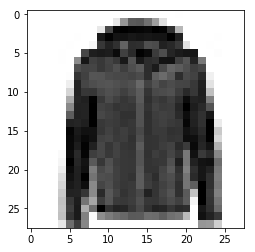

Train Accuracy: 0.88276


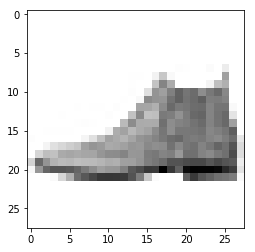

Test Accuracy: 0.87650


In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_sample, y_sample, batch_size=100):
    """Run a minibatch accuracy op"""

    N = X_sample.shape[0]
    X_sample_reshape = np.reshape(X_sample, (-1, 28, 28, 1))
    #print(X_sample_reshape.shape)
    #print(X_sample_reshape[0,10:20,10:20,0])
    correct_sample = 0
    plt.imshow(X_sample_reshape[0,:,:,0], cmap='Greys', interpolation='nearest')
    plt.show()

    for i in range(0, N, batch_size):
        X_batch = X_sample_reshape[i: i + batch_size]
        y_batch = y_sample[i: i + batch_size]
        N_batch = X_batch.shape[0]

        feed = {
            X: X_batch,
            Y: y_batch,
            is_train: False
        }

        correct_sample += sess.run(accuracy, feed_dict=feed) * N_batch

    return correct_sample / N

print("\nAccuracy Evaluates")
print("-------------------------------")
print('Train Accuracy:', '{:.5f}'.format(evaluate(mnist.train.images, mnist.train.labels)))
print('Test Accuracy:', '{:.5f}'.format(evaluate(mnist.test.images, mnist.test.labels)))

PREDICTED CLASS : 3 Dress
     TRUE CLASS : 3 Dress


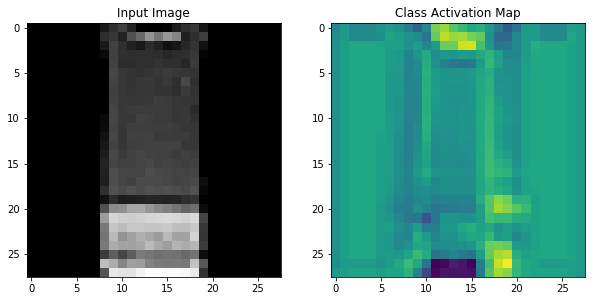

PREDICTED CLASS : 7 Sneaker
     TRUE CLASS : 7 Sneaker


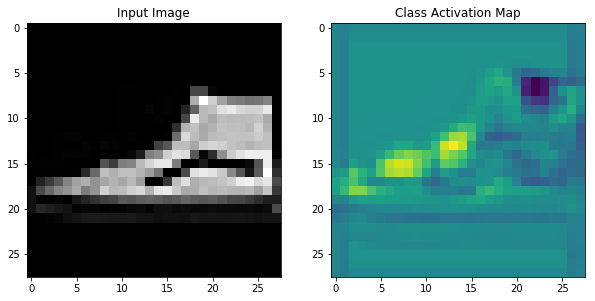

PREDICTED CLASS : 6 Shirt
     TRUE CLASS : 6 Shirt


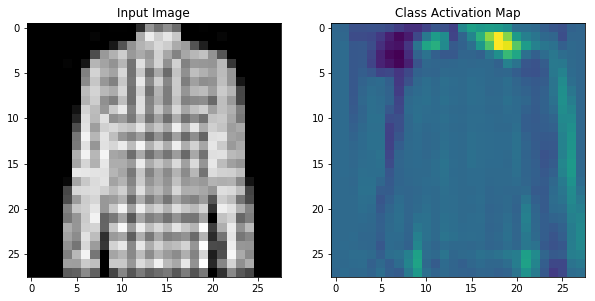

PREDICTED CLASS : 7 Sneaker
     TRUE CLASS : 7 Sneaker


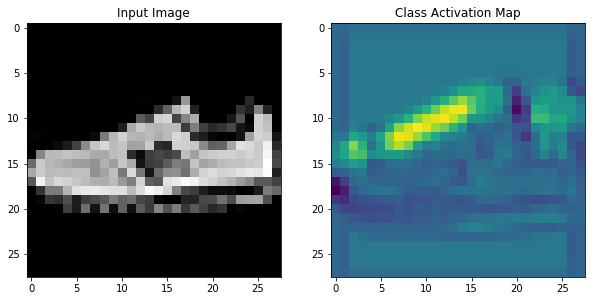

PREDICTED CLASS : 3 Dress
     TRUE CLASS : 3 Dress


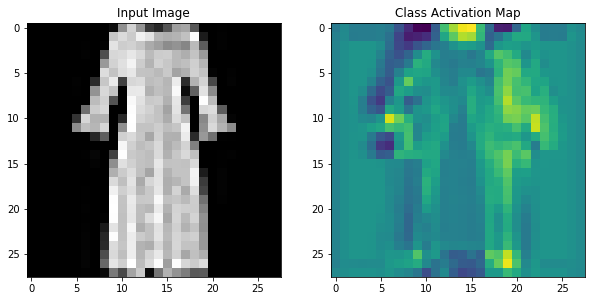

PREDICTED CLASS : 3 Dress
     TRUE CLASS : 3 Dress


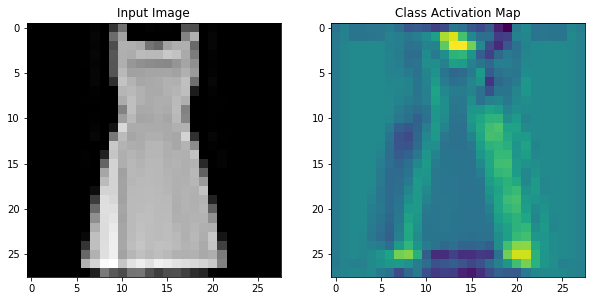

PREDICTED CLASS : 6 Shirt
     TRUE CLASS : 3 Dress


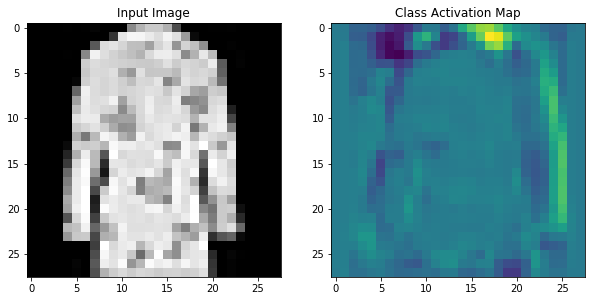

PREDICTED CLASS : 7 Sneaker
     TRUE CLASS : 5 Sandal


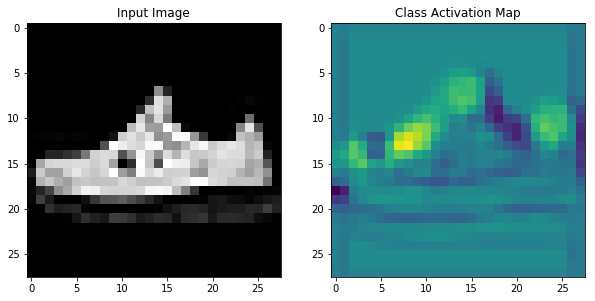

PREDICTED CLASS : 6 Shirt
     TRUE CLASS : 6 Shirt


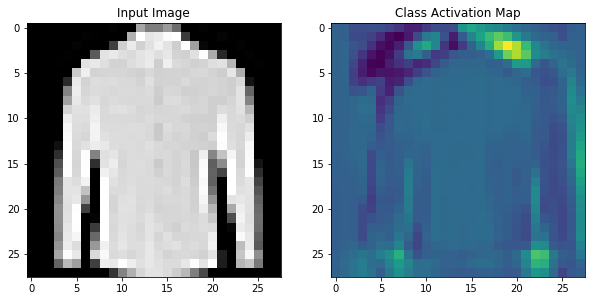

PREDICTED CLASS : 5 Sandal
     TRUE CLASS : 5 Sandal


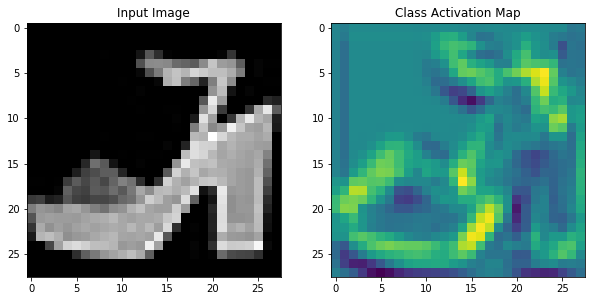

PREDICTED CLASS : 4 Coat
     TRUE CLASS : 4 Coat


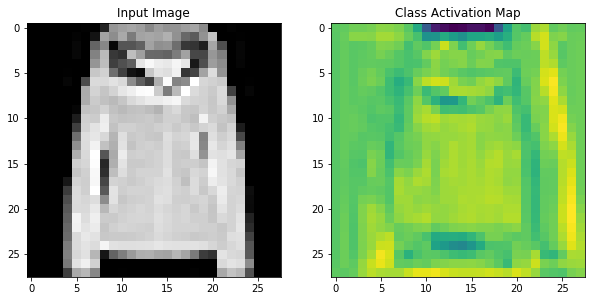

PREDICTED CLASS : 6 Shirt
     TRUE CLASS : 6 Shirt


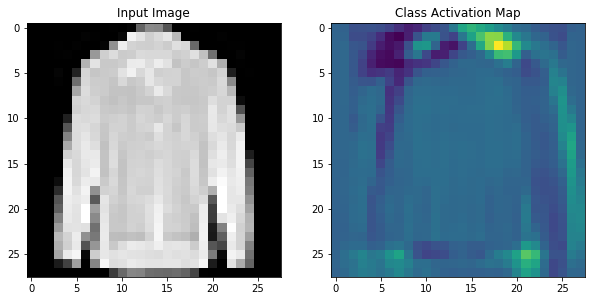

PREDICTED CLASS : 7 Sneaker
     TRUE CLASS : 7 Sneaker


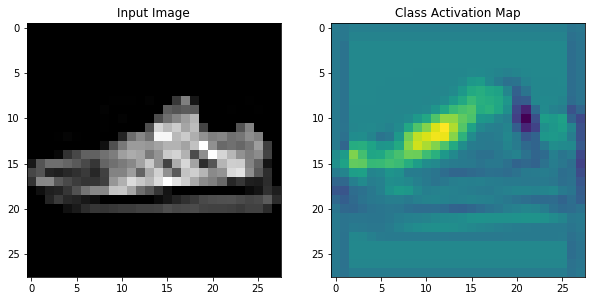

PREDICTED CLASS : 2 Pullover
     TRUE CLASS : 2 Pullover


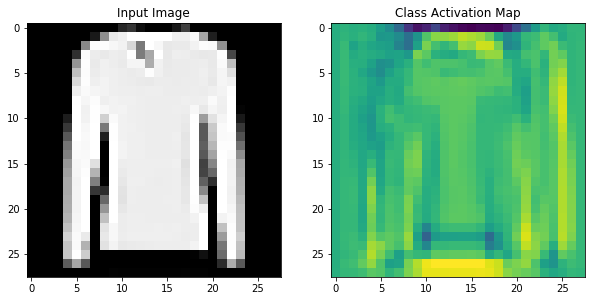

PREDICTED CLASS : 7 Sneaker
     TRUE CLASS : 7 Sneaker


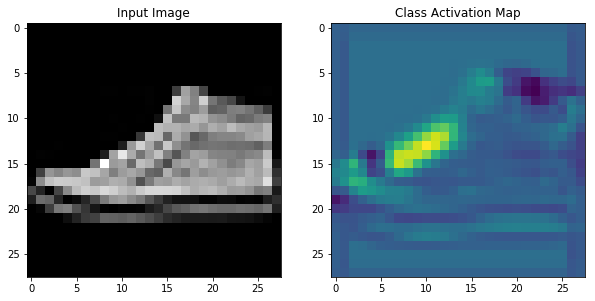

PREDICTED CLASS : 9 Ankle boot
     TRUE CLASS : 9 Ankle boot


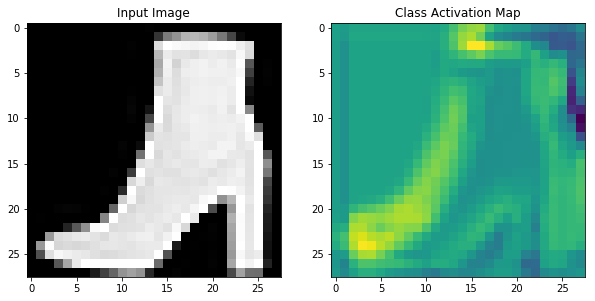

PREDICTED CLASS : 0 T-shirt/top
     TRUE CLASS : 0 T-shirt/top


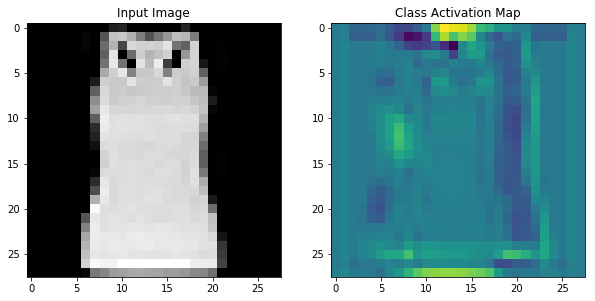

PREDICTED CLASS : 4 Coat
     TRUE CLASS : 4 Coat


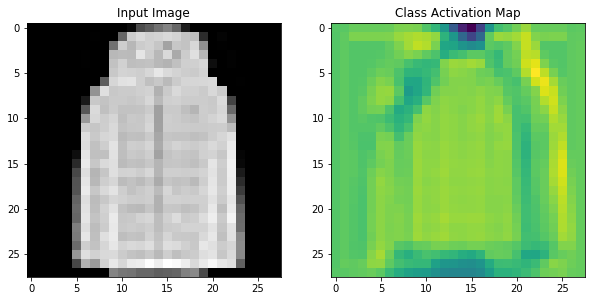

PREDICTED CLASS : 5 Sandal
     TRUE CLASS : 5 Sandal


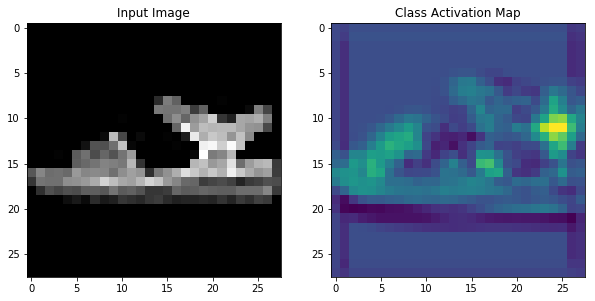

PREDICTED CLASS : 3 Dress
     TRUE CLASS : 4 Coat


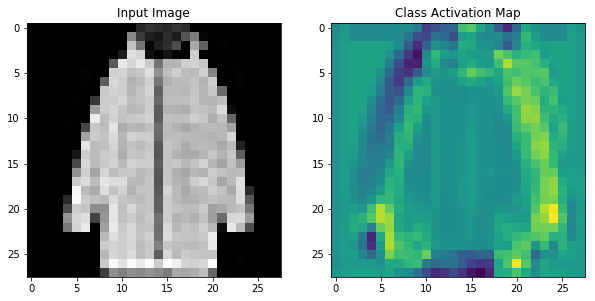

In [12]:
label_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
              'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
test_imgs = mnist.test.images
test_labels = mnist.test.labels
ntest = test_imgs.shape[0]
#print(test_labels.shape)
randidx = np.random.randint(ntest, size=20)
for idx in randidx:
    testimg = test_imgs[idx, :]
    testimg = testimg.reshape((-1,) + (28, 28, 1))
    cam_logit, cam_feat, cam_weights = sess.run([logits, conv3, weight], feed_dict={X:testimg, is_train:False})
    pred_label = np.argmax(cam_logit)
    true_label = np.argmax(test_labels[idx])
    #print(real_label)
    pred_weights = cam_weights[:, pred_label]
    #cam_sum = np.zeros((7, 7))
    cam_sum = np.zeros((28, 28))
    for i in range(128):
        cam_sum = cam_sum + pred_weights[i] * cam_feat[0, :, :, i]
    cam_avg = cam_sum / 128.
    
    print("PREDICTED CLASS : {} {}".format(pred_label, label_name[pred_label]))
    print("     TRUE CLASS : {} {}".format(true_label, label_name[true_label]))
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(1,2,1)     
    ax1.imshow(testimg[0,:,:,0], cmap='gray', interpolation='nearest')
    ax1.set_title("Input Image")
    ax2 = fig1.add_subplot(1,2,2)     
    im2 = ax2.imshow(cam_avg, origin='upper')
    ax2.set_title("Class Activation Map")
    #plt.colorbar(im2, ax=ax2)
    plt.show()